`TTbarResProcessor` Notebook for an all hadronic $t\bar{t}$ analysis: 
This notebook contains the processor necessary for analysis and is to be imported into the `TTbarResCoffeaOutputs` module.  To import it, one can ensure that this module can be ran here by executing the notebook.  If everything executes with no errors, one can create a .py file of this module by uncommenting and running the last cell in tis notebook.  That .py file is the module that is imported to create Coffea output files.

   1. Make the mistag rate in the "anti-tag" selection region,
   1. Later apply that mistag rate and the mod-mass procedure to the single-tag (pre-tag) selection. 

These are all done in bins of
b-tag categories (0, 1, $\ge 2$) and rapidity ($|y| \le 1.0$, $|y| > 1.0$).
The signal region is two top-tagged jets. 
The background estimate is the single-tag (pret) selection weighted by the mistag rate from the
"anti-tag and probe" region, with the mass of the weighted jet set to a random
value from QCD MC in the 1-ttag region. 


The preselection is:
- AK4-based $H_{T} > 950$ GeV (to be on the trigger plateau). 
- $\ge 2$ AK8 jets with AK8 $p_{T} > 400$ GeV and $|y| < 2.5$, loose jet ID applied from matched AK4 jets

The 1-tag selection adds:
- $\ge 1$ AK8 jet with top tagging applied to randomly-assigned tag jet. 


The anti-tag selection is disjoint from the 1-tag selection:
- $\ge 1$ AK8 jet with top tagging VETO applied to randomly-assigned tag jet. 


The 2-tag selection is:
- $\ge 2$ AK8 jets with top tagging applied to both leading jets. 


The ttbar candidate mass assumes the two leading top-tagged jets are the top quarks. 
# Quick Reference for Tag Region Definitions:
- An antitag and t-tagged probe pair region; numerator value of mistag [region used for closure test] (Probet)
- An antitag [and any probe pair] region; denominator value; [region used for mistag weights] (at)
- t-tagged jet0 region [region used for data-driven background estimate] (pret)
- No tops tagged (0t)
- Exclusively one jet is top tagged (1t)
- At least one jet is top tagged ['inclusive' tagger; >=1t] (1t+2t)
- Both jets are top tagged (2t)
- Either no tag or at least one tag ['all inclusive' tagger; >=0t] (0t+1t+2t)

In [1]:
executors = ['iterative', 'futures', 'dask', 'iterative test']

executor = executors[0]
print(executor)

iterative


In [2]:
import copy
import scipy.stats as ss
from coffea import hist, processor, nanoevents
from coffea import util
import numpy as np
import itertools
import pandas as pd
from numpy.random import RandomState

import awkward as ak
#from coffea.nanoevents.methods import nanoaod
from coffea.nanoevents.methods import candidate
from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoEventsFactory, BaseSchema, NanoAODSchema

from distributed import Client
import inspect
import json

# import vector

from lpcjobqueue import LPCCondorCluster

from cloudpickle import cloudpickle as cp

/opt/conda/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
For details, see https://htcondor-wiki.cs.wisc.edu/index.cgi/wiki?p=PlanToReplaceGridCommunityToolkit


In [3]:
import time
import matplotlib.pyplot as plt

In [4]:
# cluster = LPCCondorCluster(scheduler_options={'dashboard':'8785'})
#         # minimum > 0: https://github.com/CoffeaTeam/coffea/issues/465
# cluster.adapt(minimum=1, maximum=10)
# client = Client(cluster)


# client
import os

In [5]:
#ak.behavior.update(nanoaod.behavior)
# ak.behavior.update(candidate.behavior)
ak.behavior.update(vector.behavior)
# vector.register_awkward()

In [6]:
xrootdstr1 = 'root://cmseos.fnal.gov/'
xrootdstr2 = 'root://cmsxrootd.fnal.gov/'
xrootdstr3 = 'root://cmsxrootd-site.fnal.gov/'
xrootdstr4 = 'root://cms03.lcg.cscs.ch:1094/'
xrootdstr5 = 'root://cms-xrd-global.cern.ch/'
xrootdstr6 = 'root://cms02.lcg.cscs.ch:3128'
xrootdstr7 = 'root://xrootd.t2.ucsd.edu/'
xrootdstr8 = 'root://xrootd-cms.infn.it/'
xrootdstr9 = 'root://mover.pp.rl.ac.uk:1094/'

## Datasets

```
Dataset: /QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/RunIISummer20UL16NanoAOD-FlatPU0to70_106X_mcRun2_asymptotic_v13-v1/NANOAODSIM

Events: 19,883,000


Dataset: /ZprimeToTT_M3000_W30_TuneCP2_PSweights_13TeV-madgraph-pythiaMLM-pythia8/RunIISummer20UL16NanoAOD-106X_mcRun2_asymptotic_v13-v1/NANOAODSIM

Events: 490,008

```

In [8]:
jsonfiles = {
    'ZPrime':json.load(open('rootFiles/ZPrime_M3000_W30_UL20.json')),
    'QCD':json.load(open('rootFiles/QCD_Pt-15to7000_UL20_xrootd-sites.json')), #json.load(open('rootFiles/QCD_Pt-15to7000_UL20.json')),
    'TTbar':json.load(open('rootFiles/TTbar_UL20.json')),
    'TTjets':json.load(open('rootFiles/TTJets_UL20.json')),
    'Wjets':json.load(open('rootFiles/Wjets_UL20.json')),
    'JetHT':json.load(open('rootFiles/JetHT_Run2016B.json')),
}

rootfiles = {
    'ZPrime':[xrootdstr5 + f for f in jsonfiles['ZPrime']['files']],
#     'QCD':[f for f in jsonfiles['QCD']['files']],
    'QCD':['rootFiles/QCD_pt600to800_customNano_numEvents50000.root'],
    'TTbar':[xrootdstr2 + f for f in jsonfiles['TTbar']['files']],
    'TTbar':['ntupleFiles/ttbar_Mtt-1000toInf_nEvents50000.root'],
    'TTjets':[xrootdstr2 + f for f in jsonfiles['TTjets']['files']],
    'Wjets':[xrootdstr2 + f for f in jsonfiles['Wjets']['files']],
    'JetHT':[xrootdstr2 + f for f in jsonfiles['JetHT']['files']],
    'test':'rootFiles/ttbar_Mtt-1000toInf_nEvents50000.root',#'rootFiles/SMttbar_nEvents10000.root'
    
    
}


In [9]:
import uproot
x = uproot.open(rootfiles['test'])
# x = uproot.open('rootFiles/QCD_pt600to800_customNano_numEvents79200.root')

In [10]:
for z in x['Events']:
#     if 'HOTVR' in z.name:
    print(z.name)
        

run
luminosityBlock
event
nBESTCollection
BESTCollection_BEST_NNOutputs0
BESTCollection_BEST_NNOutputs1
BESTCollection_BEST_NNOutputs2
BESTCollection_BEST_NNOutputs3
BESTCollection_BEST_NNOutputs4
BESTCollection_BEST_NNOutputs5
BESTCollection_FoxWolfH1_Higgs
BESTCollection_FoxWolfH1_Top
BESTCollection_FoxWolfH1_W
BESTCollection_FoxWolfH1_Z
BESTCollection_FoxWolfH2_Higgs
BESTCollection_FoxWolfH2_Top
BESTCollection_FoxWolfH2_W
BESTCollection_FoxWolfH2_Z
BESTCollection_FoxWolfH3_Higgs
BESTCollection_FoxWolfH3_Top
BESTCollection_FoxWolfH3_W
BESTCollection_FoxWolfH3_Z
BESTCollection_FoxWolfH4_Higgs
BESTCollection_FoxWolfH4_Top
BESTCollection_FoxWolfH4_W
BESTCollection_FoxWolfH4_Z
BESTCollection_aplanarity_Higgs
BESTCollection_aplanarity_Top
BESTCollection_aplanarity_W
BESTCollection_aplanarity_Z
BESTCollection_asymmetry_Higgs
BESTCollection_asymmetry_Top
BESTCollection_asymmetry_W
BESTCollection_asymmetry_Z
BESTCollection_bDisc
BESTCollection_bDisc1
BESTCollection_bDisc2
BESTCollection_eta


In [11]:
# rootfiles['QCD'].remove('root://cmsxrootd.fnal.gov//store/mc/RunIISummer20UL16NanoAOD/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/FlatPU0to70_106X_mcRun2_asymptotic_v13-v1/50000/D5344145-46C6-F34F-9E2E-2C70FCC70564.root')


`manual_bins` is set up to define the bin sizes the user wants for the mistag rates

In [12]:
manual_bins = [400, 500, 600, 800, 1000, 1500, 2000, 3000, 7000, 10000]

All histograms that one wishes to be included in the Coffea output files is to be defined and filled in this processor.

### Functions
rapidity and deltaR not availabile in current p4 function in awkward1

In [13]:

def rapidity(fourvector):
    
#     r = .5*np.log( np.divide( (fourvector.p4.energy + fourvector.p4.pz),(fourvector.p4.energy - fourvector.p4.pz) ))
    r = .5*np.log( np.divide( (fourvector.energy + fourvector.pz),(fourvector.energy - fourvector.pz) ))

    return r
    
def deltaR2(fourvector1, fourvector2):
    
    X2 = rapidity(fourvector1)*rapidity(fourvector1) + fourvector1.p4.phi*fourvector1.p4.phi

    Y2 = rapidity(fourvector2)*rapidity(fourvector2) + fourvector2.p4.phi * fourvector2.p4.phi
    
    Z2 = ak.where(X2 > Y2, X2 - Y2, Y2 - X2)
    
    return Z2
    


In [14]:
"""@TTbarResAnaHadronic Package to perform the data-driven mistag-rate-based ttbar hadronic analysis. 
"""
class TTbarResProcessor(processor.ProcessorABC):
    

    def __init__(self, prng=RandomState(1234567890), htCut=950., minMSD=105., maxMSD=210.,
                 tau32Cut=0.65, tau32Cut_opt=0.75, deepAK8Cut=0.02, particleNetCut=0.01, ak8PtMin=400., bdisc=0.8484,
                 writePredDist=True,isData=True,year=2019, UseLookUpTables=False, lu=None, 
                 ModMass=False, RandomDebugMode=False):
        
        self.prng = prng
        self.htCut = htCut
        self.minMSD = minMSD
        self.maxMSD = maxMSD
        self.tau32Cut = tau32Cut
        self.tau32Cut_opt = tau32Cut_opt
        self.deepAK8Cut = deepAK8Cut
        self.particleNetCut = particleNetCut
        self.ak8PtMin = ak8PtMin
        self.bdisc = bdisc
        self.writePredDist = writePredDist
        self.writeHistFile = True
        self.isData = isData
        self.year=year
        self.UseLookUpTables = UseLookUpTables
        self.ModMass = ModMass
        self.RandomDebugMode = RandomDebugMode
        self.lu = lu # Look Up Tables
        
        self.ttagcats = ["Probet", "at", "pret", "0t", "1t", "1t+2t", "2t", "0t+1t+2t"] #anti-tag+probe, anti-tag, pre-tag, 0, 1, >=1, 2 ttags, any t-tag
        self.btagcats = ["0b", "1b", "2b"]   # 0, 1, >=2 btags
        self.ycats = ['cen', 'fwd']          # Central and forward
        # Combine categories like "0bcen", "0bfwd", etc:
        self.anacats = [ t+b+y for t,b,y in itertools.product( self.ttagcats, self.btagcats, self.ycats) ]
        #print(self.anacats)
        
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        cats_axis = hist.Cat("anacat", "Analysis Category")
        tagcat_axis = hist.Cat("taggerName", "Tagger")
        
        jetmass_axis = hist.Bin("jetmass", r"Jet $m$ [GeV]", 50, 0, 5000)
        jetpt_axis = hist.Bin("jetpt", r"Jet $p_{T}$ [GeV]", 30, 0, 3000)
        ttbarmass_axis = hist.Bin("ttbarmass", r"$m_{t\bar{t}}$ [GeV]", 50, 0, 5000)
        jeteta_axis = hist.Bin("jeteta", r"Jet $\eta$", 50, -5, 5)
        jetphi_axis = hist.Bin("jetphi", r"Jet $\phi$", 50, -np.pi, np.pi)
        jety_axis = hist.Bin("jety", r"Jet $y$", 50, -3, 3)
        jetdy_axis = hist.Bin("jetdy", r"Jet $\Delta y$", 50, 0, 5)
        manual_axis = hist.Bin("jetp", r"Jet Momentum [GeV]", manual_bins)
        tagger_axis = hist.Bin("tagger", r"Tagger", 500, 0, 1)
        tau32_axis = hist.Bin("tau32", r"$\tau_3/\tau_2$", 100, 0, 1)
        csvv2_axis = hist.Bin("csvv2", r"CSV v2", 100, 0, 1)
        deltaR_axis = hist.Bin("deltaR", r"$\Delta R$", 50, 0, 5)
        
        subjetmass_axis = hist.Bin("subjetmass", r"SubJet $m$ [GeV]", 50, 0, 500)
        subjetpt_axis = hist.Bin("subjetpt", r"SubJet $p_{T}$ [GeV]", 50, 0, 2000)
        subjeteta_axis = hist.Bin("subjeteta", r"SubJet $\eta$", 50, -4, 4)
        subjetphi_axis = hist.Bin("subjetphi", r"SubJet $\phi$", 50, -np.pi, np.pi)

        self._accumulator = processor.dict_accumulator({
            
#             'ttbarmass': hist.Hist("Counts", dataset_axis, ttbarmass_axis),
            

            'jetpt':     hist.Hist("Counts", dataset_axis, jetpt_axis),
            'jetmass':     hist.Hist("Counts", dataset_axis, jetmass_axis),
            
            'ttbarcands_pt':     hist.Hist("Counts", dataset_axis, jetpt_axis),
            'ttbarcands_mass':     hist.Hist("Counts", dataset_axis, jetmass_axis),
       
            'h_deepAK8MD':   hist.Hist("Counts", dataset_axis, jetpt_axis, tagger_axis),
            'h_HOTVR':   hist.Hist("Counts", dataset_axis, jetpt_axis, tagger_axis),
            'h_particleNet':   hist.Hist("Counts", dataset_axis, jetpt_axis, tagger_axis),
            'h_tau32':       hist.Hist("Counts", dataset_axis, jetpt_axis, tau32_axis, csvv2_axis),
            'h_CSVV2':       hist.Hist("Counts", dataset_axis, jetpt_axis, tau32_axis),
       
            'cutflow': processor.defaultdict_accumulator(int),
            
            'deepAK8': processor.defaultdict_accumulator(int),
            'particleNet': processor.defaultdict_accumulator(int),
            'tau32': processor.defaultdict_accumulator(int),
            
            'deepAK8_msdCut': processor.defaultdict_accumulator(int),
            'particleNet_msdCut': processor.defaultdict_accumulator(int),
            'tau32_msdCut': processor.defaultdict_accumulator(int),

   
            'jetpt_deepAK8':     hist.Hist("Counts", dataset_axis, jetpt_axis),
            'jetpt_tau32':     hist.Hist("Counts", dataset_axis, jetpt_axis),
            'jetpt_tau32_opt':     hist.Hist("Counts", dataset_axis, jetpt_axis),
            'jetpt_particleNet':     hist.Hist("Counts", dataset_axis, jetpt_axis),
       
            
        })
            
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, events):
        
        output = self.accumulator.identity()
        
        # ---- Define dataset ---- #
        dataset = events.metadata['dataset']
        


#         FatJets = ak.with_name(events.FatJet, "PtEtaPhiMLorentzVector")
#         SubJets = ak.with_name(events.SubJet, "PtEtaPhiMLorentzVector")
#         GenParts = ak.with_name(events.GenPart, "PtEtaPhiMLorentzVector")
    
    
        FatJets = events.FatJet
#         SubJets = events.SubJet
#         GenParts = events.customGenParticles
        hotvrJets = events.HOTVR
       
        # ---- Get event weights from dataset ---- #
        if 'JetHT' in dataset: # If data is used...
            evtweights = np.ones(ak.count(FatJets.pt)) # set all "data weights" to one
        else: # if Monte Carlo dataset is used...
            evtweights = events.Generator.weight
        # ---- Show all events ---- #
        output['cutflow']['all events'] += len(hotvrJets)
        
        
        
        
        # require N subjets >= 3
        
        
        nSubJets = (hotvrJets.nSubjets >= 3)
        
        hotvrJets = hotvrJets[nSubJets]
        
        output['cutflow']['N SubJets'] += len(hotvrJets)
        
        
        
        
        # require leading subjet pt / jet pt < 0.8

        ptratio = ((hotvrJets.subjet0Pt / hotvrJets.pt) < 0.8)
        
        print(ptratio)
        
        hotvrJets = hotvrJets[ptratio]
        
        output['cutflow']['pt ratio'] += len(hotvrJets)
        
        
        
        # require 140 < jet mass < 220
        

        
        massCut = ((hotvrJets.mass > 140) & (hotvrJets.mass < 220))
        
        
        hotvrJets = hotvrJets[massCut]
        
        output['cutflow']['mass cut'] += len(hotvrJets)
        
        
        pairs = ak.cartesian([hotvrJets, hotvrJets])
        

        onePair = (ak.num(pairs) >= 1)
        

        hotvrJets = hotvrJets[onePair]
        pairs = pairs[onePair]
           
        
        output['cutflow']['one pair'] += len(hotvrJets)
        

        # require minimum mass > 50 GeV
        
                
        cands = ak.with_name(pairs.slot0, "PtEtaPhiMLorentzVector") + ak.with_name(pairs.slot1, "PtEtaPhiMLorentzVector")
        
        
#         massMinCut = (ak.min(cands.mass, axis=-1) > 50)

        massMinCut = (hotvrJets.m_min > 50)
        
        print('minmass', ak.min(cands.mass, axis=-1))
        print(massMinCut)

        hotvrJets = hotvrJets[massMinCut]
        pairs = pairs[massMinCut]
        
        
        output['cutflow']['min mass'] += len(hotvrJets)
        
        
        
        tau32 = np.where(hotvrJets.tau2 > 0, hotvrJets.tau3 / hotvrJets.tau2, -1)
        
        
        print(tau32)
        
  
        output['h_HOTVR'].fill(dataset=dataset,
                              jetpt = ak.flatten(hotvrJets.pt),
                              tagger = ak.flatten(tau32),
                             )
        
        
        
        
        
        
        print()
     
        return output

    def postprocess(self, accumulator):
        return accumulator



In [15]:




if (executor == "dask"):
    if __name__ == "__main__":
        tic = time.time()
        cluster = LPCCondorCluster()
        # minimum > 0: https://github.com/CoffeaTeam/coffea/issues/465
        cluster.adapt(minimum=1, maximum=10)
        client = Client(cluster)
#         client.upload_file('TTbarResProcessor_nb.py')

if(executor == "dask"):
    client

In [16]:
tstart = time.time()

# chunksize of 100,000 takes iterative executor 2 hrs for QCD


filesets = {
#     'ZPrime':rootfiles['ZPrime'],
#     'QCD':rootfiles['QCD'],
    'TTbar':rootfiles['TTbar'],
#     'Wjets':rootfiles['Wjets'],
#     'test':[rootfiles['test']],

}
# filesets



outputs_unweighted = {}

seed = 1234577890
prng = RandomState(seed)
Chunk = [10000, 100] # [chunksize, maxchunks]


for name,files in filesets.items():
    
    if(executor=="dask"):
        output = processor.run_uproot_job({name:files},
                                          treename='Events',
                                          processor_instance=TTbarResProcessor(UseLookUpTables=False,
                                                                               ModMass=False, 
                                                                               prng=prng,
                                                                              ),
                                          executor=processor.dask_executor,
                                          executor_args={
                                              'client': client,
                                              'schema': NanoAODSchema,
#                                               'workers': 2
                                          }
                                          ,
                                          chunksize=100000,
                                         )
        
    elif(executor=="futures"):
        output = processor.run_uproot_job({name:files},
                                          treename='Events',
                                          processor_instance=TTbarResProcessor(UseLookUpTables=False,
                                                                               ModMass=False, 
                                                                               prng=prng,
                                                                              ),
                                          executor=processor.futures_executor,
                                          executor_args={
                                              'schema': NanoAODSchema,
                                              'workers': 2
                                          }
                                          ,
                                          chunksize=100000,
#                                           maxchunks=10,
                                         )

    elif(executor=="iterative test"):
        output = processor.run_uproot_job({name:files},
                                          treename='Events',
                                          processor_instance=TTbarResProcessor(UseLookUpTables=False,
                                                                               ModMass=False, 
                                                                               prng=prng,
                                                                              ),
                                          executor=processor.iterative_executor,
                                          executor_args={
                                              'schema': NanoAODSchema,
                                          },
                                          chunksize=1000,
                                          maxchunks=10,
                                          
                                         )
        
    else:
        output = processor.run_uproot_job({name:files},
                                          treename='Events',
                                          processor_instance=TTbarResProcessor(UseLookUpTables=False,
                                                                               ModMass=False, 
                                                                               prng=prng,
                                                                              ),
                                          executor=processor.iterative_executor,
                                          executor_args={
                                              'schema': NanoAODSchema,
                                          },
                                          chunksize=100000,
                                         )

    elapsed = time.time() - tstart
    outputs_unweighted[name] = output
    
    elapsed = time.time() - tstart
    print(elapsed)

    print()

Preprocessing:   0%|          | 0/1 [00:00<?, ?file/s]

Processing:   0%|          | 0/1 [00:00<?, ?chunk/s]

[[], [True], [], [True, True], [False], [], ... [], [], [], [True], [True], [True]]
minmass [304, 372, 314, 301, 416, 342, 352, 352, ... 302, 364, 382, 320, 348, 325, 404, 391]
[[True], [True], [True, True], [True], ... True], [True], [True], [True], [True]]
[[0.318], [0.454], [0.521, 0.295], [0.487], ... [0.386], [0.484], [0.374], [0.277]]

2.9611148834228516



In [17]:
output['cutflow']

defaultdict_accumulator(int,
                        {'all events': 50000,
                         'N SubJets': 50000,
                         'pt ratio': 50000,
                         'mass cut': 50000,
                         'one pair': 12919,
                         'min mass': 12919})

In [18]:


# for file in rootfiles['QCD']:
#     try:
#         x = uproot.open(file)
#     except:
#         print(file)




In [19]:
# rfile='root://t2-xrdcms.lnl.infn.it:7070//store/mc/RunIISummer20UL16NanoAOD/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/FlatPU0to70_106X_mcRun2_asymptotic_v13-v1/50000/0479CC19-8AEA-BE41-AF12-A533FFEB68CB.root'

# x = uproot.open(rfile)


In [20]:
# x['Events']

In [21]:
namestring = ''
Nevents = 0
Nsamples = len(filesets.keys())

for name in filesets.keys():
    
    if 'test' in name:
        namestring = namestring + 'TTbar' + '_'
    else:
        namestring = namestring + name + '_'
        
        
    if Nsamples > 1:
        Nevents = Nevents + output[name]['cutflow']['all events']
    else:
        Nevents = Nevents + output['cutflow']['all events']
    
print(namestring)
print('Nevents', Nevents)


TTbar_
Nevents 50000


In [22]:
# output['h_HOTVR'].scale({():5}, axis='jetpt')

output['h_HOTVR'].axis('jetpt')

<Bin (name=jetpt) instance at 0x7f01425f98e0>

In [23]:
print(jsonfiles['ZPrime']['events'])
print(jsonfiles['QCD']['events'])

490008
19883000


In [24]:
save_filename = 'CoffeaOutputs/TTbarResCoffea_' + namestring + str(Nevents) + 'events_HOTVR.coffea'
# save_filename = 'CoffeaOutputs/TTbarResCoffea_' + namestring + '10000b' + 'events.coffea'
util.save(output, save_filename)

print('saving ' + save_filename)

saving CoffeaOutputs/TTbarResCoffea_TTbar_50000events_HOTVR.coffea


In [25]:
# run all above

In [26]:


Zfilename = 'TTbarResCoffea_ZPrime_490008events.coffea'

Zfilename = 'TTbarResCoffea_TTbar_50000events_HOTVR.coffea'



# custom ntuple
QCDfilename = 'TTbarResCoffea_QCD_79200events_HOTVR.coffea'


In [27]:
# output_sig = util.load('CoffeaOutputs/'+filename)['ZPrime']
# output_bkg = util.load('CoffeaOutputs/'+filename)['QCD']

output_sig = util.load('CoffeaOutputs/'+Zfilename)
output_bkg = util.load('CoffeaOutputs/'+QCDfilename)


## ROC Curves

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [29]:
# output_sig['h_deepAK8'].sum('dataset').sum('jetpt').values()[()]

In [30]:
sig_values = []
bkg_values = []

t_bins = [b.hi for b in output_sig['h_tau32'].axis('tau32')][:-2]






# for BIN in output_sig['h_HOTVR'].axis('tagger'):
for i in range(len(t_bins)):
    
    t_interval = hist.Interval(0, t_bins[i])
    
    try:
        vs = output_sig['h_HOTVR'].sum('dataset').sum('jetpt').integrate('tagger',t_interval).values()[()]
    except:
        continue
    try:
        vb = output_bkg['h_HOTVR'].sum('dataset').sum('jetpt').integrate('tagger',t_interval).values()[()]
    except:
        continue


    

    
    sig_values.append(vs)
    bkg_values.append(vb)
    
        
print(len(sig_values))
print(len(bkg_values))

101
101


/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=tagger) instance at 0x7f0144158f70>: requested stop 0.35000000000000003 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=tagger) instance at 0x7f0144158430>: requested stop 0.35000000000000003 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=tagger) instance at 0x7f0144158f70>: requested stop 0.41000000000000003 between bin boundaries, no interpolation is performed
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/hist/hist_tools.py:658: RuntimeWarning: Reducing along axis <Bin (name=tagger) instance at 0x7f0144158430>: requested stop 0.41000000000000003 between bin boundaries, no inte

In [31]:
t_bins

[0.0,
 0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.06,
 0.07,
 0.08,
 0.09,
 0.1,
 0.11,
 0.12,
 0.13,
 0.14,
 0.15,
 0.16,
 0.17,
 0.18,
 0.19,
 0.2,
 0.21,
 0.22,
 0.23,
 0.24,
 0.25,
 0.26,
 0.27,
 0.28,
 0.29,
 0.3,
 0.31,
 0.32,
 0.33,
 0.34,
 0.35000000000000003,
 0.36,
 0.37,
 0.38,
 0.39,
 0.4,
 0.41000000000000003,
 0.42,
 0.43,
 0.44,
 0.45,
 0.46,
 0.47000000000000003,
 0.48,
 0.49,
 0.5,
 0.51,
 0.52,
 0.53,
 0.54,
 0.55,
 0.56,
 0.5700000000000001,
 0.58,
 0.59,
 0.6,
 0.61,
 0.62,
 0.63,
 0.64,
 0.65,
 0.66,
 0.67,
 0.68,
 0.6900000000000001,
 0.7000000000000001,
 0.71,
 0.72,
 0.73,
 0.74,
 0.75,
 0.76,
 0.77,
 0.78,
 0.79,
 0.8,
 0.81,
 0.8200000000000001,
 0.8300000000000001,
 0.84,
 0.85,
 0.86,
 0.87,
 0.88,
 0.89,
 0.9,
 0.91,
 0.92,
 0.93,
 0.9400000000000001,
 0.9500000000000001,
 0.96,
 0.97,
 0.98,
 0.99,
 1.0]

/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/opt/conda/lib/python3.8/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


Text(0.5, 0, 'HOTVR $\\tau_3 / \\tau_2$')

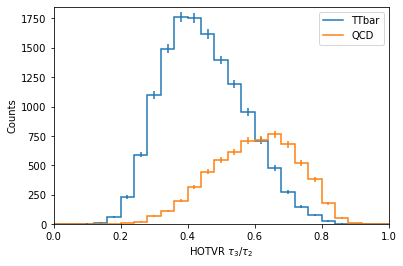

In [32]:
hist.plot1d(output_sig['h_HOTVR'].sum('dataset').sum('jetpt').rebin('tagger', 20))
hist.plot1d(output_bkg['h_HOTVR'].sum('dataset').sum('jetpt').rebin('tagger', 20))

plt.legend(['TTbar', 'QCD'])
plt.xlabel(r'HOTVR $\tau_3 / \tau_2$')

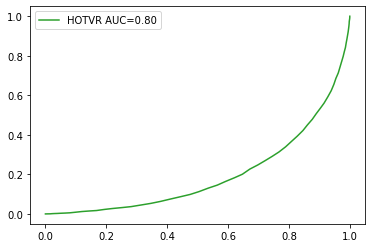

In [33]:

sigmax = output_sig['h_HOTVR'].sum('dataset').sum('jetpt').sum('tagger').values()[()]
bkgmax = output_bkg['h_HOTVR'].sum('dataset').sum('jetpt').sum('tagger').values()[()]


sig = (np.array(sig_values)/sigmax)[:-1]
bkg = (np.array(bkg_values)/bkgmax)[:-1]

roc_auc = auc(bkg, sig)

plt.plot(sig, bkg, color='C2', label='HOTVR AUC={0:0.2f}'.format(roc_auc))

plt.legend()
# plt.yscale('log')
plt.show()

In [34]:
auc(bkg, sig)

0.8035343246470397

In [35]:
f = np.load('ttbar_ttagger.npz')

In [36]:
sig_deepak8 = f['sig']
bkg_deepak8 = f['bkg']
auc_deepak8 = auc(bkg_deepak8, sig_deepak8)

In [37]:
sig_ttagger = f['sig']
bkg_ttagger = f['bkg']
auc_ttagger = f['auc']

In [38]:
import mplhep as hep

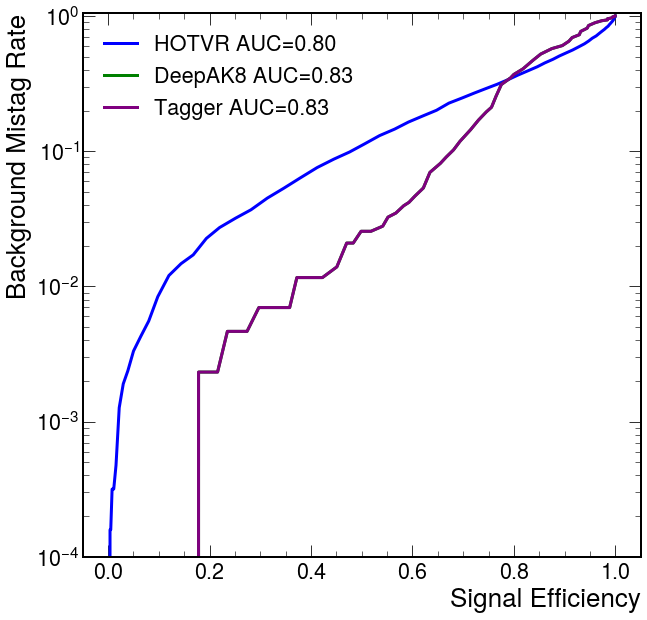

In [42]:

hep.style.use(hep.style.ROOT)

lw=3

with plt.style.context(hep.style.ROOT):
    
    plt.plot(sig, bkg, color='blue', lw=lw, label='HOTVR AUC={0:0.2f}'.format(roc_auc))
#     plt.plot(sig_deepak8, bkg_deepak8, color='green', lw=lw, label='DeepAK8 AUC={0:0.2f}'.format(auc_deepak8))
    plt.plot(sig_ttagger, bkg_ttagger, color='purple', lw=lw, label='Tagger AUC={0:0.2f}'.format(auc_ttagger))


    
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-4, 1.05)
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Mistag Rate')
    plt.show()

In [40]:



hep.style.use(hep.style.ROOT)

lw=3

with plt.style.context(hep.style.ROOT):
    
    plt.plot(sig, bkg, color='C2', lw=lw, label='deepAK8 AUC={0:0.2f}'.format(roc_auc_DA))
#     plt.plot(sig_PN, bkg_PN, color='C3', lw=lw, label='particleNet AUC={0:0.2f}'.format(roc_auc_PN))
    plt.plot(sig_T, bkg_T, color='C4', lw=lw, label='Tagger AUC={0:0.2f}'.format(roc_auc_T))


    
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-4, 1.05)
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Mistag Rate')
    plt.show()

NameError: name 'roc_auc_DA' is not defined

In [ ]:
ttbar = (np.array(ttbar_values)/ttbarmax)[:-1]
bkg = (np.array(bkg_values)/bkgmax)[:-1]
ttbar_PN = (np.array(ttbar_values_PN)/ttbarmax)[:-1]
bkg_PN =( np.array(bkg_values_PN)/bkgmax)[:-1]
ttbar_T = (np.array(ttbar_values_T)/ttbarmax)
bkg_T =( np.array(bkg_values_T)/bkgmax)


In [ ]:
ttbarmax = np.max(ttbar_values)
bkgmax = np.max(bkg_values)



ttbar = (np.array(ttbar_values)/ttbarmax)[:-1]
bkg = (np.array(bkg_values)/bkgmax)[:-1]
# ttbar_PN = (np.array(ttbar_values_PN)/ttbarmax)[:-1]
# bkg_PN =( np.array(bkg_values_PN)/bkgmax)[:-1]
ttbar_T = (np.array(ttbar_values_T)/ttbarmax)
bkg_T =( np.array(bkg_values_T)/bkgmax)

lw=3


roc_ttbar_DA = auc(bkg, ttbar)
# roc_auc_PN = auc(bkg_PN, sig_PN)
roc_ttbar_T = auc(bkg_T, ttbar_T)

with plt.style.context(hep.style.ROOT):
    
    plt.plot(ttbar, bkg, color='C2', lw=lw, label='deepAK8 AUC={0:0.2f}'.format(roc_ttbar_DA))
#     plt.plot(ttbar_PN, bkg_PN, color='C3', lw=lw, label='particleNet AUC={0:0.2f}'.format(roc_auc_PN))
    plt.plot(ttbar_T, bkg_T, color='C4', lw=lw, label='Tagger AUC={0:0.2f}'.format(roc_ttbar_T))


    
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-4, 1.05)
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Mistag Rate')
    plt.show()

In [41]:
ttbarmax = np.max(ttbar_values)
wjetsmax = np.max(wjets_values)



ttbar = (np.array(ttbar_values)/ttbarmax)[:-1]
wjets = (np.array(wjets_values)/wjetsmax)[:-1]
# ttbar_PN = (np.array(ttbar_values_PN)/ttbarmax)[:-1]
# wjets_PN =( np.array(wjets_values_PN)/wjetsmax)[:-1]
ttbar_T = (np.array(ttbar_values_T)/ttbarmax)
wjets_T =( np.array(wjets_values_T)/wjetsmax)

lw=3

with plt.style.context(hep.style.ROOT):
    
    plt.plot(ttbar, bkg, color='C2', lw=lw, label='deepAK8 AUC={0:0.2f}'.format(roc_auc_DA))
    plt.plot(ttbar_T, bkg_T, color='C4', lw=lw, label='deepAK8 AUC={0:0.2f}'.format(roc_auc_T))

#     plt.plot(ttbar_PN, wjets_PN, color='C3', lw=lw, label='particleNet AUC={0:0.2f}'.format(roc_auc_PN))
#     plt.plot(ttbar_T, wjets_T, color='C4', lw=lw, label='Tagger AUC={0:0.2f}'.format(roc_auc_T))


    
    plt.legend()
    plt.yscale('log')
    plt.ylim(1e-4, 1.05)
    plt.xlabel('Signal Efficiency')
    plt.ylabel('Background Mistag Rate')
    plt.show()

NameError: name 'ttbar_values' is not defined

In [ ]:
946934 / 27304804

In [ ]:
output_sig['cutflow']

In [ ]:
hist.plot1d(output_sig['jetpt'].sum('dataset'))

In [ ]:
hist.plot1d(output_sig['ttbarcands_mass'].sum('dataset'))

In [ ]:
hist.plot1d(output_sig['ttbarcands_pt'].sum('dataset'))

In [ ]:
hist.plot1d(output_bkg['jetpt'].sum('dataset'))

In [ ]:
output_sig['cutflow']

output_sig['ttjets']['all']